In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [11]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CSV
        self.df = pd.read_csv("data\\case\\ILINet.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)][["ILITOTAL","% WEIGHTED ILI","TOTAL PATIENTS"]]

        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        
        self.data = np.asarray(self.df,dtype=np.float32)
        # print(self.data)
        self.norm = np.linalg.norm(self.data, axis=0)
        # print(self.norm)
        self.data = self.data / self.norm
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        # idx = 0
        return self.data[idx:idx+self.numFeat],self.data[idx+self.numFeat:idx+self.numFeat+self.numOut]
    
    def getNorm(self):
        return self.norm

In [12]:
#create data loaders
numFeat = 10
numOut = 4
batchSize = 64
train_data = dataSetAll(2020,2022,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=batchSize,drop_last=False,shuffle=True)

test_data = dataSetAll(2022,2100,numFeat,numOut)
test_dataloader = DataLoader(train_data, batch_size=batchSize,drop_last=False,shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\case\\ILINet.csv'

In [ ]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 3
sequenceLength = numFeat
numLayers = 1
hiddenSize = 32

class RNN(nn.Module):
    def __init__(self,inputSize,hiddenSize,numLayers,numOut,sequenceLength,future=0):
        super(RNN, self).__init__()
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.numOut = numOut
        self.future = future
        self.inputSize = inputSize
        # print(batchSize,sequenceLength,inputSize)
        # self.LSTM = nn.LSTM(inputSize,hiddenSize,numLayers,batch_first=True)
        self.rnn = nn.RNNCell(inputSize,hiddenSize)
        # self.rnn2 = nn.RNNCell(1,hiddenSize,nonlinearity='tanh')
        self.fc = nn.Linear(hiddenSize,inputSize)
        
    def forward(self,x):
        nSamples = x.size(0)
        outputs = torch.zeros([nSamples,4,self.inputSize])
        h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        h_2 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)

        for input in x.split(1,dim=1):
            # print(input[:,0,:].size())
            h_1 = self.rnn(input[:,0,:], h_1)
            out = self.fc(h_1)
        outputs[:,0] = out
            # h_2 = h_1
        for i in range(self.numOut-1):
            h_1 = self.rnn(out, h_1)
            out = self.fc(h_1)
            outputs[:,i+1] = out

        # outputs = torch.as_tensor(outputs)
        return outputs

model = RNN(inputSize,hiddenSize,numLayers,numOut,sequenceLength)

In [ ]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.size())
        # X = X[:,:,None]
        # print(X.size())
        pred = model(X)
        # break
        # print(pred.size())
        # print(y.size())
        # print("pred",pred.size())
        # print("Y",y.size())
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
learning_rate = .001
epochs = 1000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print(list(model.parameters()))

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # break
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 0.023237  [    0/   91]
loss(1): 0.014270  [    0/   91]
loss(2): 0.007968  [    0/   91]
loss(3): 0.003748  [    0/   91]
loss(4): 0.001439  [    0/   91]
loss(5): 0.000812  [    0/   91]
loss(6): 0.001566  [    0/   91]
loss(7): 0.002360  [    0/   91]
loss(8): 0.002558  [    0/   91]
loss(9): 0.001997  [    0/   91]
loss(10): 0.001457  [    0/   91]
loss(11): 0.000901  [    0/   91]
loss(12): 0.000753  [    0/   91]
loss(13): 0.000787  [    0/   91]
loss(14): 0.000945  [    0/   91]
loss(15): 0.000960  [    0/   91]
loss(16): 0.000980  [    0/   91]
loss(17): 0.001054  [    0/   91]
loss(18): 0.000906  [    0/   91]
loss(19): 0.000813  [    0/   91]
loss(20): 0.000610  [    0/   91]
loss(21): 0.000548  [    0/   91]
loss(22): 0.000608  [    0/   91]
loss(23): 0.000760  [    0/   91]
loss(24): 0.000775  [    0/   91]
loss(25): 0.000642  [    0/   91]
loss(26): 0.000641  [    0/   91]
loss(27): 0.000794  [    0/   91]
loss(28): 0.000699  [    0/   91]
loss(29): 0.000722  [   

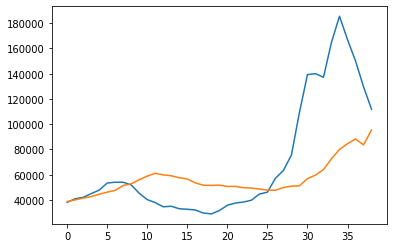

Test Error:
Avg loss: 0.000091 



In [ ]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # print(X)
            pred = model(X)
            # print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    print(f"Test Error:\nAvg loss: {test_loss:>8f} \n")

def test(model):
    test_data = dataSetAll(2018,2100,numFeat,numOut)
    norm = test_data.getNorm()
    with torch.no_grad():
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            Y = test_data[idx][1]*norm
            feat = X[None,:]
            pred = model(feat)[0]*norm
            pred = pred[:,0] 
            Y = Y[:,0]  
            plt.plot(Y)
            plt.plot(pred)
            
            plt.show()


def graph(model):
    norm = test_data.getNorm()
    with torch.no_grad():
        predY = []
        actY = []
        res = []
        for idx in range(len(test_data)):
            X = test_data[idx][0]
            y = test_data[idx][1]*norm
            feat = X[None,:]

            pred = model(feat)[0]*norm
            future = 3

            # predY.append(pred[numFeat-1::][future])
            # actY.append(y[numFeat-1::][future]) 
            pred = pred[:,0] 
            y = y[:,0]  
            # print(pred.size())
            # print(float(pred[3]))
            predY.append(pred[future])
            actY.append(y[future])    
            res.append(pred[future]-y[future])
            
        plt.plot(actY) 
        plt.plot(predY)
        # plt.hist(res)
        plt.show()
        # print(np.std(res))

graph(model)
# test(model)
test_loop(test_dataloader,model,loss_fn)
